In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
from torch.utils.data import DataLoader

loaders ={
    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),
    'test' : DataLoader(test_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),
}

In [11]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff1c1cf2eb0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ff1c1cf2e80>}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # avoid memorizing data
        self.fc1 = nn.Linear(320, 50) # 320 depends on size of x
        self.fc2 = nn.Linear(50, 10) # softmax for all digits
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        print(x.shape)
        x = x.view(-1, 320) # 20*4*4
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x)





In [13]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch__idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch__idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch__idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch__idx / len(loaders["train"]):.0f})%]\t{loss.item(): .6f}')


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders['test'].dataset)

    print(f'\nTest Set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')
 

In [14]:
save_path = "model.pth"

for epoch in range (1, 100):
    train(epoch)
    test()
    torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

/tmp/ipykernel_1125/1314962905.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0)%]	 2.304362
Train Epoch: 1 [2000/60000 (3)%]	 2.257946
Train Epoch: 1 [4000/60000 (7)%]	 2.036017
Train Epoch: 1 [6000/60000 (10)%]	 1.887309
Train Epoch: 1 [8000/60000 (13)%]	 1.862816
Train Epoch: 1 [10000/60000 (17)%]	 1.757831
Train Epoch: 1 [12000/60000 (20)%]	 1.721220
Train Epoch: 1 [14000/60000 (23)%]	 1.687835
Train Epoch: 1 [16000/60000 (27)%]	 1.703795
Train Epoch: 1 [18000/60000 (30)%]	 1.695656
Train Epoch: 1 [20000/60000 (33)%]	 1.669159
Train Epoch: 1 [22000/60000 (37)%]	 1.671308
Train Epoch: 1 [24000/60000 (40)%]	 1.601776
Train Epoch: 1 [26000/60000 (43)%]	 1.587158
Train Epoch: 1 [28000/60000 (47)%]	 1.623127
Train Epoch: 1 [30000/60000 (50)%]	 1.654384
Train Epoch: 1 [32000/60000 (53)%]	 1.626887
Train Epoch: 1 [34000/60000 (57)%]	 1.647910
Train Epoch: 1 [36000/60000 (60)%]	 1.584972
Train Epoch: 1 [38000/60000 (63)%]	 1.643200
Train Epoch: 1 [40000/60000 (67)%]	 1.583163
Train Epoch: 1 [42000/60000 (70)%]	 1.609058
Train Epoch: 1 [44000

In [15]:
device

device(type='cuda')

Prediction: 9


/tmp/ipykernel_1125/1314962905.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


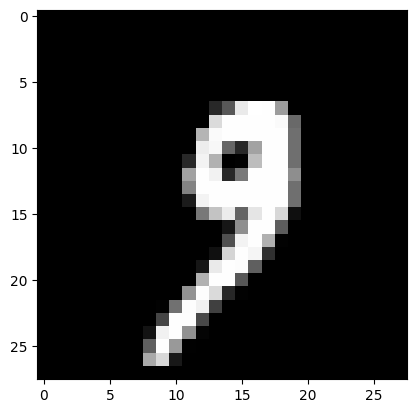

In [16]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[1000]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

Prediction: 4


/tmp/ipykernel_1125/2616269675.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))
/tmp/ipykernel_1125/1314962905.py:23: User

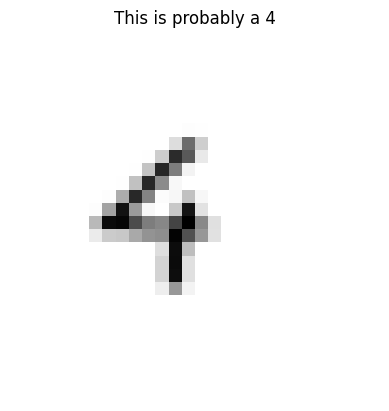

In [29]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Initialize the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)  # Replace MyModel with your actual model class

model.load_state_dict(torch.load("model.pth"))
model.eval()  # Set to evaluation mode for inference

# Define the device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a custom image
def load_and_preprocess_image(image_path):
    # Load the image using PIL and convert to grayscale if needed
    image = Image.open(image_path).convert("L")  # Convert to grayscale if required by your model

    # Define the transformations (adjust based on model training)
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize to match input dimensions
        transforms.ToTensor(),        # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize as per training normalization
    ])

    # Apply the transformations and add batch dimension
    image = transform(image).unsqueeze(0).to(device)
    return image

# Define the path to your custom image
image_path = "Custom-test-data/s-4.png"  # Replace with the path to your custom image

# Load and preprocess the image
data = load_and_preprocess_image(image_path)

# Make a prediction
with torch.no_grad():
    output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()

# Display prediction
print(f'Prediction: {prediction}')

# Convert tensor back to numpy for display
image = data.squeeze(0).squeeze(0).cpu().numpy()

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'This is probably a {prediction}')
plt.axis('off')
plt.show()

